# Deep Learning Black Scholes
The goal of this case study is to perform derivative pricing from a machine learning standpoint and use supervised regression-based model to learn the Black-Scholes option pricing model from simulated data.


<a id='0'></a>
# 1. Problem Definition

In the supervised regression framework used for this case study, the derivative pricing
problem is defined in the regression framework, where the predicted variable is the
pricing of the option, and the predictor variables are the market data that are used as
inputs to the Black-Scholes option pricing model

Options have been used in finance as means to hedge risk in a nonlinear manner. They are are also used by speculators in order to take leveraged bets in the financial markets. Historically, people have used the Black Scholes formula.

$$  Se^{-q \tau}\Phi(d_1) - e^{-r \tau} K\Phi(d_2) \, $$

With

$$  d_1 = \frac{\ln(S/K) + (r - q + \sigma^2/2)\tau}{\sigma\sqrt{\tau}}  $$

and

$$  d_2 = \frac{\ln(S/K) + (r - q - \sigma^2/2)\tau}{\sigma\sqrt{\tau}} = d_1 - \sigma\sqrt{\tau}  $$

Where we have;
    Stock price $S$;
    Strike price $K$;
    Risk-free rate $r$;
    Annual dividend yield $q$;
    Time to maturity $\tau = T-t$ (represented as a unit-less fraction of one year);
    Volatility $\sigma$

In order to make the logic simpler, we define *Moneyness* as $M = K/S$ and look at the prices in terms of per unit of current stock price. We also set $q$ as $0$ 

This simplifes the formula down to the following

$$  S e^{-q \tau}\Phi\left( \frac{- \ln(M) + (r+ \sigma^2/2 )\tau}{\sigma\sqrt{\tau}}\right) - S e^{-r \tau} M\Phi\left( \frac{- \ln(M) + (r - \sigma^2/2)\tau}{\sigma\sqrt{\tau}} \right) \, $$

### Python Imports

In [1]:
# Distribution functions
from scipy.stats import norm


# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

#Plotting 
from pandas.plotting import scatter_matrix

In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
## 2.2. Defining functions and parameters

### True Parameters

In [3]:
# riskless rate and initial stock price
r = 0.02
s0 = 100.0

### Vol and Option Pricing Functions

In [4]:
def call_option_price(s0, M, t, v):
    # Black Scholes Equation
    d1=(-np.log(M)+(r+np.square(v)/2)*t)/(v*np.sqrt(t))
    d2=(-np.log(M)+(r-np.square(v)/2)*t)/(v*np.sqrt(t))
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    return s0 * N_d1 - s0 * M * np.exp(-r*t) * N_d2

In [5]:
# to capture the skew
def option_vol(m):
    a = 0.35
    b = -0.1
    c = 0.02
    vol = a + b*m + c*m*m
    return vol

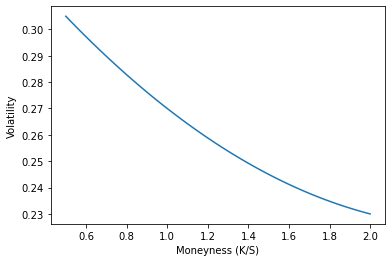

In [6]:
moneyness = np.linspace(0.5, 2.0, 100)
v = option_vol(moneyness)
plt.plot(moneyness, v);
plt.xlabel("Moneyness (K/S)")
plt.ylabel("Volatility");

## Data Generation

Generate option prices for a range of K, T, sigma holding r fixed 

In [7]:
N = 10000

Ms = (0.5+1.0*np.random.random(N)) #moneyness with mean around 1
Ts = np.random.random(N) * 5.0 #expiration time 
Vs = option_vol(Ms) #volatility
Ps = np.array([call_option_price(s0, m, t, v) for m, t, v in zip(Ms,Ts,Vs)])

In [10]:
Ps

array([6.06696664e+00, 5.38384290e+01, 1.73831144e-03, ...,
       3.97301324e-01, 1.38777362e+01, 4.54002220e+01])

### Set the Endog and Exog Data

In [11]:
Y = Ps

X = np.concatenate([Ms.reshape(-1,1), Ts.reshape(-1,1), Vs.reshape(-1,1)], axis=1)

dataset = pd.DataFrame(np.concatenate([Y.reshape(-1,1), X], axis=1),
                       columns=['Price', 'Moneyness', 'Time', 'Volatility'])

In [12]:
dataset.head()

,Price,Moneyness,Time,Volatility
0,6.066967,1.326531,2.042141,0.252541
1,53.838429,0.520163,3.778165,0.303395
2,0.001738,1.396029,0.164696,0.249375
3,1.245372,1.219718,0.436665,0.257782
4,29.515667,0.883773,3.745972,0.277244


<a id='2.2'></a>
## 3.2. Data Visualization

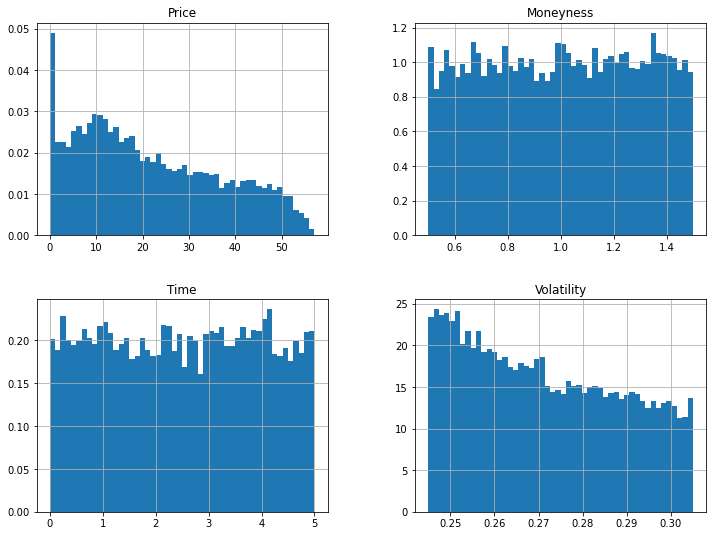

In [13]:
dataset.hist(bins=50, density=True, sharex=False, sharey=False, xlabelsize=10, ylabelsize=10, figsize=(12,9));

We can see that the price has an interesting distribution with a spike at $0$ due to all of the OTM options. Strike is Gaussian distributed around 100 and the time is uniformally distributed out to 5 years

Next we look at the interaction between different variables

## Data Preparation and Analysis

### Univariate Feature Selection

We use SelectKBest function from sklearn

In [14]:
bestfeatures = SelectKBest(k='all', score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(['Strike', 'Time', 'Vol'])
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
Vol,64172.703809
Strike,51422.753429
Time,1292.024002


<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split and Evaluation Metrics

In [15]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

We use the prebuilt scikit models to run a K fold analysis on our training data. We then train the model on the full training data and use it for prediction of the test data. The parameters for the K fold analysis are defined as -

In [16]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

## Training an MLP in Scikit Learn

In [17]:
from sklearn.neural_network import MLPRegressor

In [18]:
models = []
models.append(('MLP', MLPRegressor()))

In [19]:
names = []
kfold_results = []
test_results = []
train_results = []

for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    
    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

MLP: 0.969698 (0.716248) 0.791245 0.751929


We begin by looking at the Kfold analysis

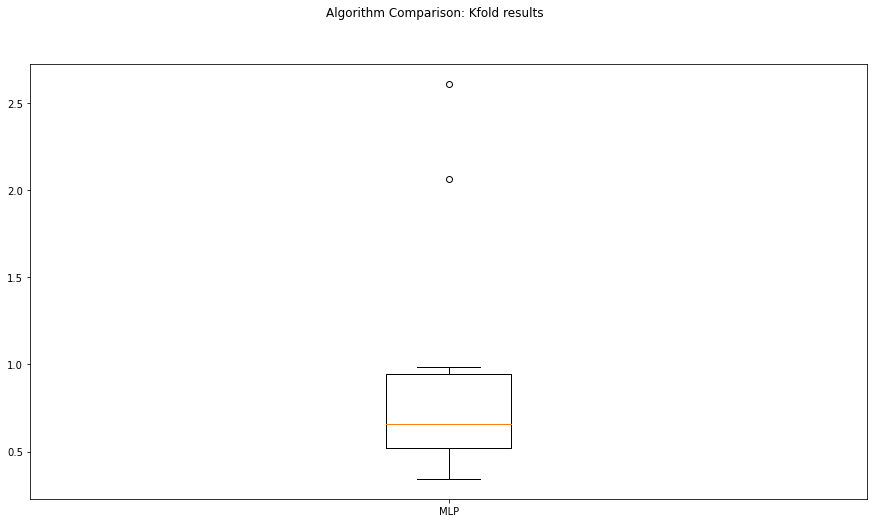

In [20]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

Let's look out of sample

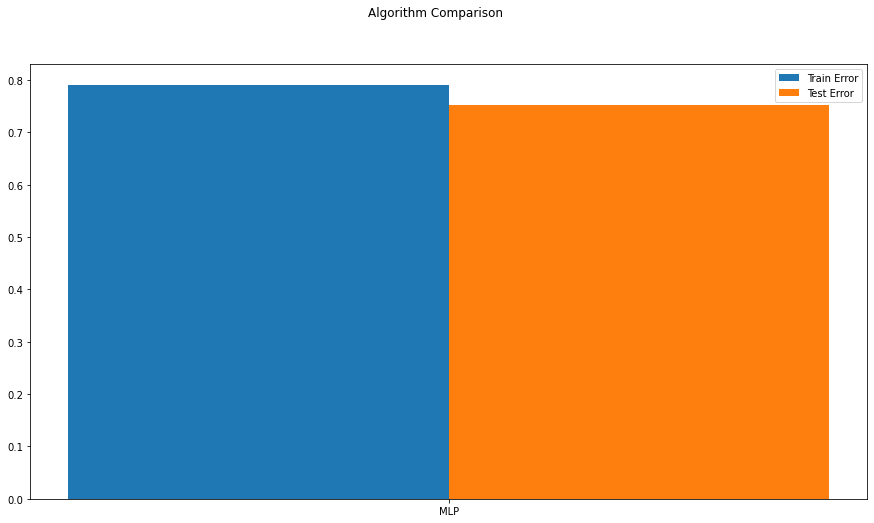

In [21]:
# compare algorithms
fig = plt.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_results,  width=width, label='Train Error')
plt.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.show()

We see that the multilayer perceptron (MLP) algorithm does a lot better that the linear algorithm. Given MLP is one of the best models we perform the grid search for MLP model in the next step.  

<a id='5'></a>
# 6. Finalising the model

In [22]:
models

[('MLP', MLPRegressor())]

In [23]:
# prepare model
name, mlp = models[-1]

In [25]:
# estimate accuracy on validation set
# transform the validation dataset
predictions = mlp.predict(X_test)
print(mean_squared_error(Y_test, predictions))

0.7519285922040281


## Examination of the Fit

We see how good the fit is for different moneyness, volatility and times to maturity.

In [55]:
def plot_fit(model,tmat):

    s0 = 100.0
    strike = np.linspace(0.7*s0, 1.3*s0, 100)
    moneyness = strike / s0
    time_to_maturity = np.ones(100)*tmat
    option_vol_vector = option_vol(moneyness)

    bs_price = call_option_price(s0, moneyness, time_to_maturity, option_vol_vector)

    X = np.array([moneyness, time_to_maturity, option_vol_vector]).transpose()
    predicted_price = model.predict(X)

    plt.plot(strike, bs_price, label='Black Scholes')
    plt.plot(strike, predicted_price, label='Predicted Price')
    plt.xlabel("Strike")
    plt.ylabel("Call Option Value")
    plt.title("Expiry in " + str(tmat) + " year(s)")
    plt.legend();

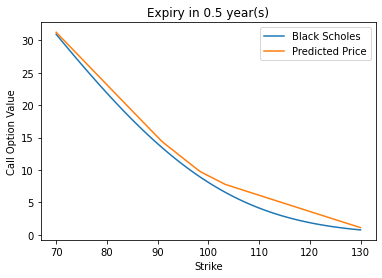

In [56]:
plot_fit(res,0.50)

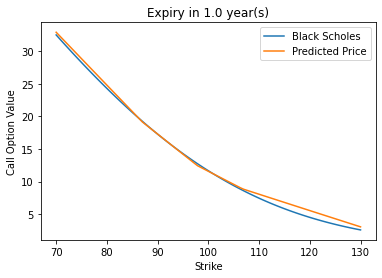

In [57]:
plot_fit(res,1.0)

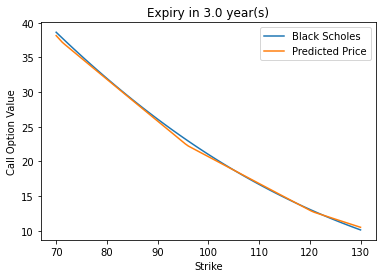

In [58]:
plot_fit(res,3.0)

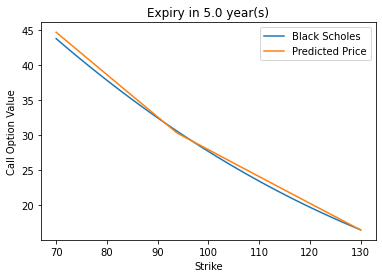

In [59]:
plot_fit(res,5.0)

### Summary

Artificial neural network (ANN) can reproduce the Black and Scholes option pricing formula for a call option to a reasonable degree of accuracy which means that we can leverage the efficient numerical calculation of machine learning in the derivative pricing without relying on the impractical assumptions made in the traditional derivative pricing models. 

### Use Keras to approximate BSM pricing

In [33]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Input,Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [34]:
# define a adaptive learning rate
def ada_lr(maxiter):
    lr_vals=[]
    for i in range(1,maxiter+1):
        lr_vals.append(np.exp(1-maxiter/(maxiter+1-i)))
    return lr_vals

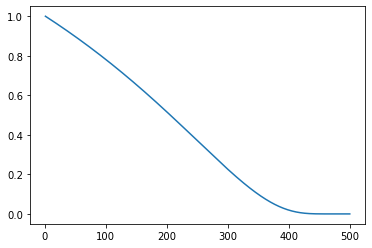

In [35]:
maxiter = 500
iteration = np.linspace(1,maxiter,maxiter)
plt.plot(iteration,ada_lr(maxiter))

In [36]:
tf_model = Sequential()
tf_model.add(Dense(100,activation='relu',input_shape = X_train.shape[1:]))
tf_model.add(Dense(1))

In [37]:
tf_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               400       
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________


In [43]:
tf_model.compile(optimizer=SGD(lr=1e-3,nesterov=True), loss='mean_squared_error')

In [44]:
results = tf_model.fit(X_train,Y_train,epochs=50,validation_data=(X_test,Y_test))

Epoch 1/50
250/250 [==============================] - 0s 859us/step - loss: 0.0583 - val_loss: 0.0573
Epoch 2/50
250/250 [==============================] - 0s 586us/step - loss: 0.0577 - val_loss: 0.0561
Epoch 3/50
250/250 [==============================] - 0s 554us/step - loss: 0.0570 - val_loss: 0.0567
Epoch 4/50
250/250 [==============================] - 0s 563us/step - loss: 0.0565 - val_loss: 0.0577
Epoch 5/50
250/250 [==============================] - 0s 550us/step - loss: 0.0559 - val_loss: 0.0540
Epoch 6/50
250/250 [==============================] - 0s 570us/step - loss: 0.0557 - val_loss: 0.0559
Epoch 7/50
250/250 [==============================] - 0s 562us/step - loss: 0.0549 - val_loss: 0.0530
Epoch 8/50
250/250 [==============================] - 0s 685us/step - loss: 0.0543 - val_loss: 0.0530
Epoch 9/50
250/250 [==============================] - 0s 690us/step - loss: 0.0537 - val_loss: 0.0538
Epoch 10/50
250/250 [==============================] - 0s 582us/step - loss: 0.053

In [40]:
results.history.keys()

dict_keys(['loss', 'val_loss'])

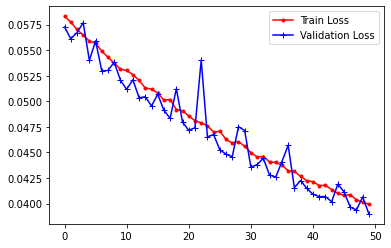

In [45]:
fig, ax = plt.subplots()
ax.plot(results.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(results.history["val_loss"],'b', marker='+', label="Validation Loss")
ax.legend()

In [46]:
results_2 = tf_model.fit(X_train,Y_train,epochs=250,validation_data=(X_test,Y_test))

Epoch 1/250
250/250 [==============================] - 0s 989us/step - loss: 0.0397 - val_loss: 0.0400
Epoch 2/250
250/250 [==============================] - 0s 843us/step - loss: 0.0394 - val_loss: 0.0383
Epoch 3/250
250/250 [==============================] - 0s 606us/step - loss: 0.0391 - val_loss: 0.0393
Epoch 4/250
250/250 [==============================] - 0s 582us/step - loss: 0.0389 - val_loss: 0.0405
Epoch 5/250
250/250 [==============================] - 0s 592us/step - loss: 0.0388 - val_loss: 0.0379
Epoch 6/250
250/250 [==============================] - 0s 601us/step - loss: 0.0383 - val_loss: 0.0375
Epoch 7/250
250/250 [==============================] - 0s 775us/step - loss: 0.0383 - val_loss: 0.0376
Epoch 8/250
250/250 [==============================] - 0s 630us/step - loss: 0.0382 - val_loss: 0.0373
Epoch 9/250
250/250 [==============================] - 0s 695us/step - loss: 0.0380 - val_loss: 0.0370
Epoch 10/250
250/250 [==============================] - 0s 558us/step - l

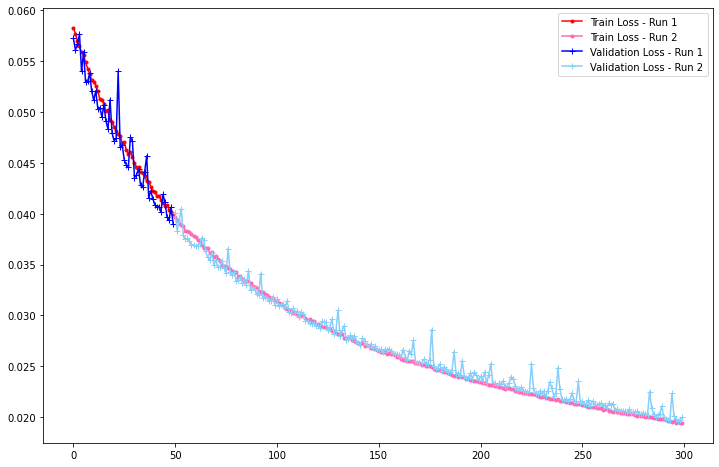

In [47]:
n = len(results.history["loss"])
m = len(results_2.history['loss'])
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(range(n), results.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), results_2.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), results.history["val_loss"],'b', marker='+', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), results_2.history["val_loss"], 'LightSkyBlue', marker='+',  label="Validation Loss - Run 2")

ax.legend()

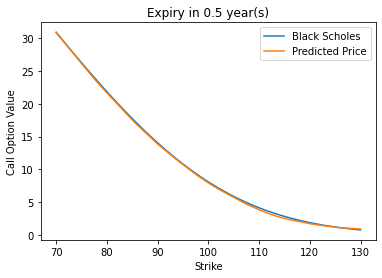

In [60]:
plot_fit(tf_model,0.5)

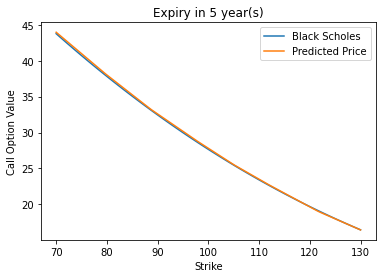

In [62]:
plot_fit(tf_model,5)